In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage import data, io, filters

In [6]:
new_model = tf.keras.models.load_model('saved_model')

In [8]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 298, 298, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_18 (ReLU)                (None, 298, 298, 64  0           ['conv2d_18[0][0]']              
                                )                                                           

                                                                                                  
 concatenate_5 (Concatenate)    (None, 36, 36, 512)  0           ['cropping2d_5[0][0]',           
                                                                  'up_sampling2d_5[0][0]']        
                                                                                                  
 conv2d_30 (Conv2D)             (None, 34, 34, 256)  1179904     ['concatenate_5[0][0]']          
                                                                                                  
 re_lu_30 (ReLU)                (None, 34, 34, 256)  0           ['conv2d_30[0][0]']              
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 128)  295040      ['re_lu_30[0][0]']               
                                                                                                  
 re_lu_31 

In [100]:
import os
data = []
!cp -r "../signal_processing_project/Test/" "./"
os.makedirs("./test_images") 
os.makedirs("./test_masks") 

In [101]:
SHAPE = (250,250)
for dirname, _, filenames in os.walk("./Test"):
    if "normal" not in dirname:
        for filename in filenames:
            if "mask" not in filename and "DS_Store" not in filename:
                d1 = dirname.split('/')[2]
                d2 = os.path.join('./test_images', filename)
                d3 = os.path.join('./test_masks',filename)
                os.replace(dirname+"/"+filename.replace('.png','') + ("_mask.png"), "./test_masks/" + filename)
                os.replace(dirname+"/"+filename, "./test_images/" + filename)

                data.append([d1,d2,d3])
df = pd.DataFrame(data, columns=['category','image','mask'])
df

category                              image  \
0   malignant  ./test_images/malignant (206).png   
1   malignant  ./test_images/malignant (178).png   
2   malignant  ./test_images/malignant (197).png   
3   malignant  ./test_images/malignant (181).png   
4   malignant  ./test_images/malignant (210).png   
..        ...                                ...   
77     benign     ./test_images/benign (433).png   
78     benign     ./test_images/benign (425).png   
79     benign     ./test_images/benign (405).png   
80     benign     ./test_images/benign (413).png   
81     benign     ./test_images/benign (429).png   

                                mask  
0   ./test_masks/malignant (206).png  
1   ./test_masks/malignant (178).png  
2   ./test_masks/malignant (197).png  
3   ./test_masks/malignant (181).png  
4   ./test_masks/malignant (210).png  
..                               ...  
77     ./test_masks/benign (433).png  
78     ./test_masks/benign (425).png  
79     ./test_masks/benign (405).png  
80     ./test_masks/benign (413).png  
81     ./test_masks/benign (429).png  

[82 rows x 3 columns]

In [102]:
IMAGE_SIZE = (300,300)

for i in df.itertuples():
    img = io.imread(i.image)
    mask = io.imread(i.mask)

Index(['category', 'image', 'mask'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


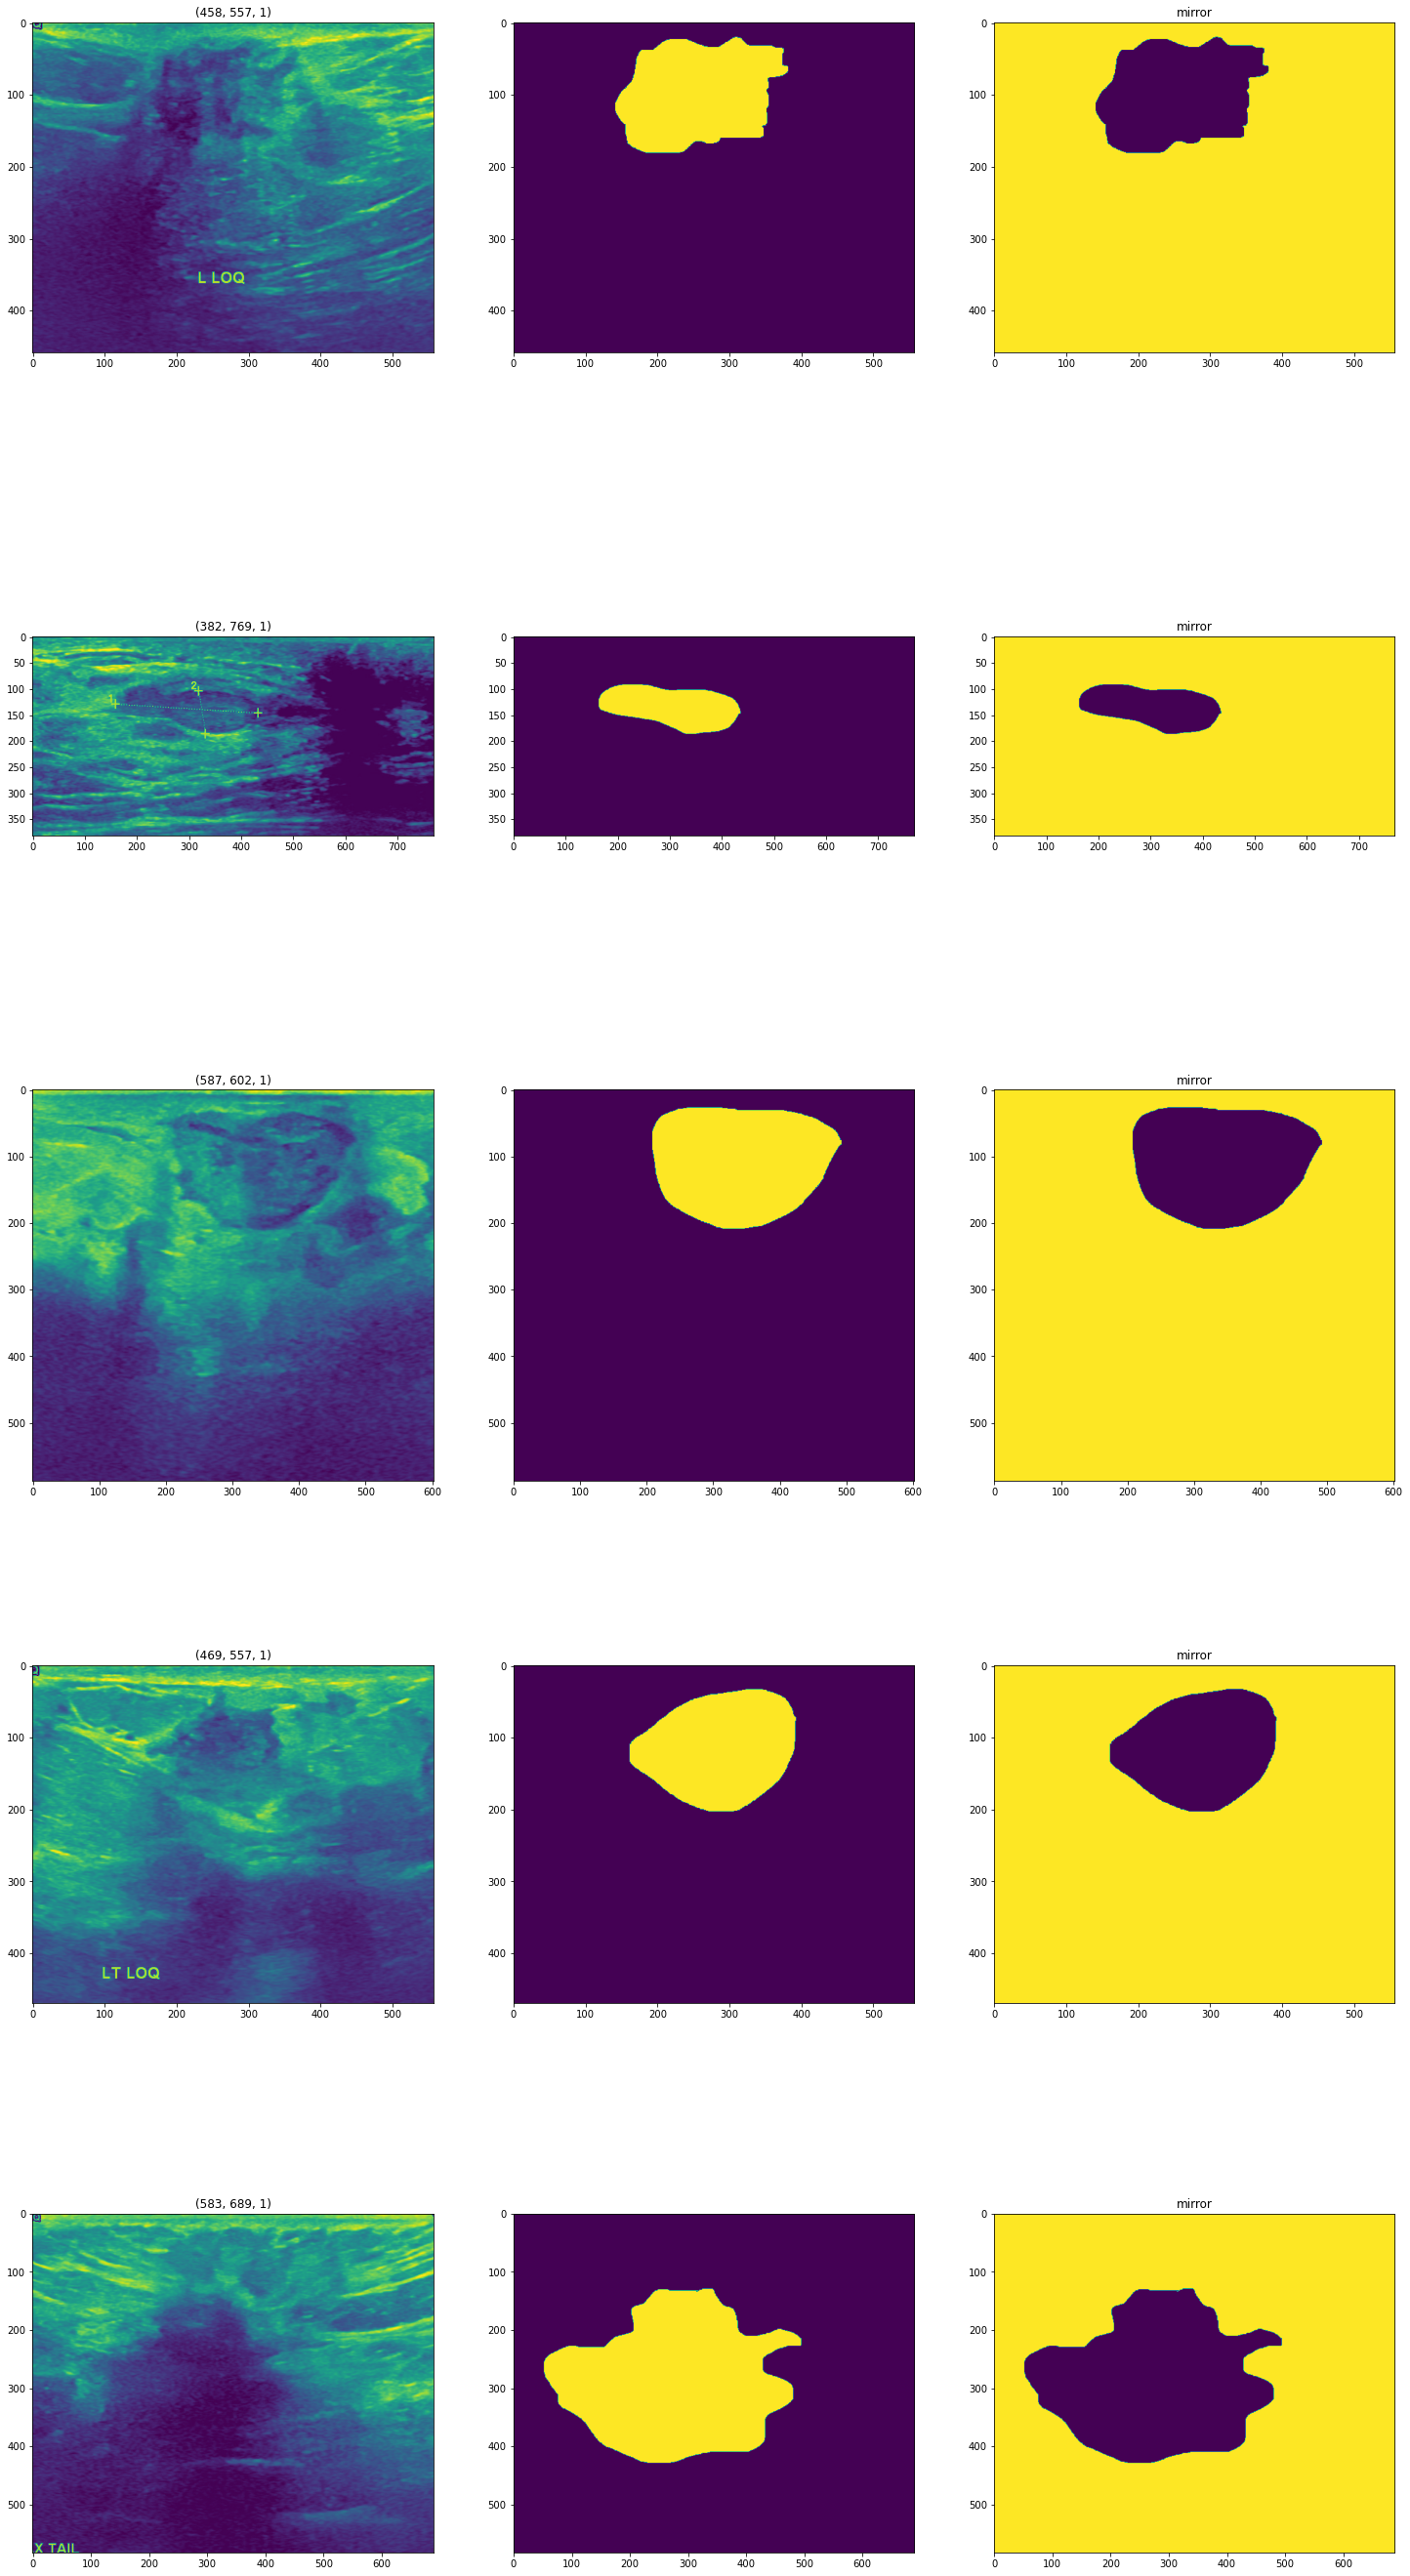

In [103]:
IMAGE_SIZE = (250,250)

n=5
samples = df.sample(n=n, random_state=1)
print(samples.columns)
print(type(samples))
fig, axs = plt.subplots(n,3,figsize=(n*5,n*10))

for idx,i in enumerate(samples.itertuples()):
    mask = tf.io.read_file(i.mask)
    img = tf.io.read_file(i.image)
    
    img = tf.image.decode_jpeg(img, channels=1)
    mask = tf.image.decode_jpeg(mask, channels=1)
    
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mirror = (mask+1)%2
    reshaped = tf.image.resize(img, size=[SHAPE[0],SHAPE[1]])    
    axs[idx,0].set_title(str(img.shape))
    axs[idx,0].imshow(img)
    axs[idx,1].imshow(mask)
    axs[idx,2].set_title(str("mirror"))
    axs[idx,2].imshow(mirror)  

In [104]:
def process_img(file_path,shape=SHAPE,ismask=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[shape[0],shape[1]])
    if ismask:
        mirror = (img+1)%2
        return tf.concat([img,mirror],2)
    return img

In [105]:
from glob import glob

x_files = glob('./test_images/*.png')
y_files = glob('./test_masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = new_model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

(116, 116, 2)


In [106]:
predicttest = new_model.predict(files_ds)

In [107]:
print(predicttest[0])

[[[2.0042409e-03 9.9799573e-01]
  [2.0188428e-03 9.9798113e-01]
  [2.0323582e-03 9.9796766e-01]
  ...
  [6.3626457e-04 9.9936372e-01]
  [6.2115624e-04 9.9937880e-01]
  [6.1669730e-04 9.9938333e-01]]

 [[2.0247523e-03 9.9797529e-01]
  [2.0545530e-03 9.9794549e-01]
  [2.0698474e-03 9.9793017e-01]
  ...
  [6.3091866e-04 9.9936908e-01]
  [6.0679507e-04 9.9939322e-01]
  [6.0065778e-04 9.9939930e-01]]

 [[2.1046966e-03 9.9789524e-01]
  [2.1456908e-03 9.9785429e-01]
  [2.1726328e-03 9.9782735e-01]
  ...
  [6.1661616e-04 9.9938333e-01]
  [5.9527851e-04 9.9940467e-01]
  [5.9269415e-04 9.9940729e-01]]

 ...

 [[1.7526482e-01 8.2473516e-01]
  [1.7420173e-01 8.2579821e-01]
  [1.7283255e-01 8.2716745e-01]
  ...
  [7.9110354e-02 9.2088962e-01]
  [7.4963413e-02 9.2503655e-01]
  [6.9378421e-02 9.3062156e-01]]

 [[1.7267521e-01 8.2732475e-01]
  [1.7090620e-01 8.2909381e-01]
  [1.6961129e-01 8.3038867e-01]
  ...
  [7.1596801e-02 9.2840314e-01]
  [6.8146408e-02 9.3185353e-01]
  [6.3170217e-02 9.3682975e-

In [108]:
new_model.evaluate(files_ds)

82/82 [==============================] - 33s 397ms/step - loss: 0.3815 - accuracy: 0.8628 - auc_1: 0.9045


[0.38149309158325195, 0.8628021478652954, 0.9044783115386963]

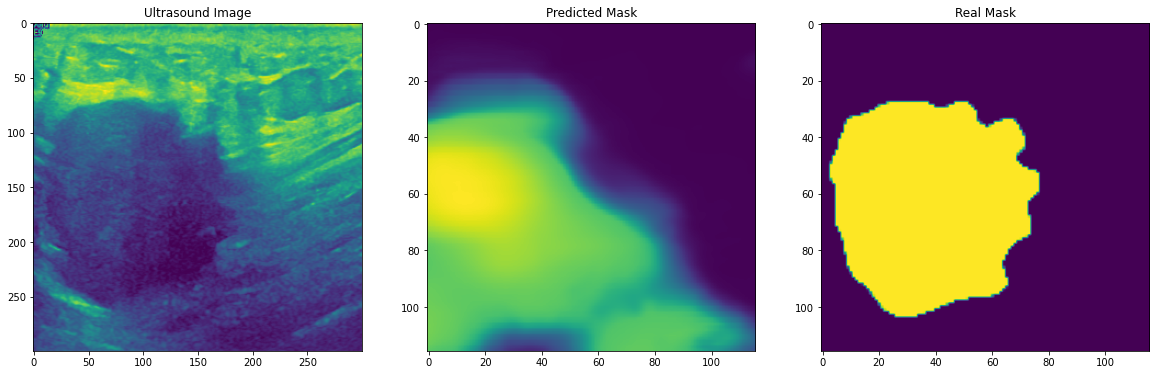

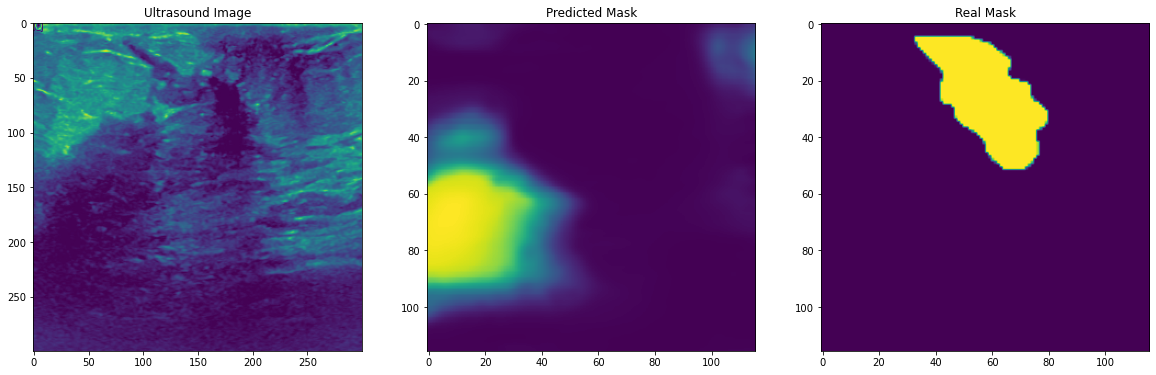

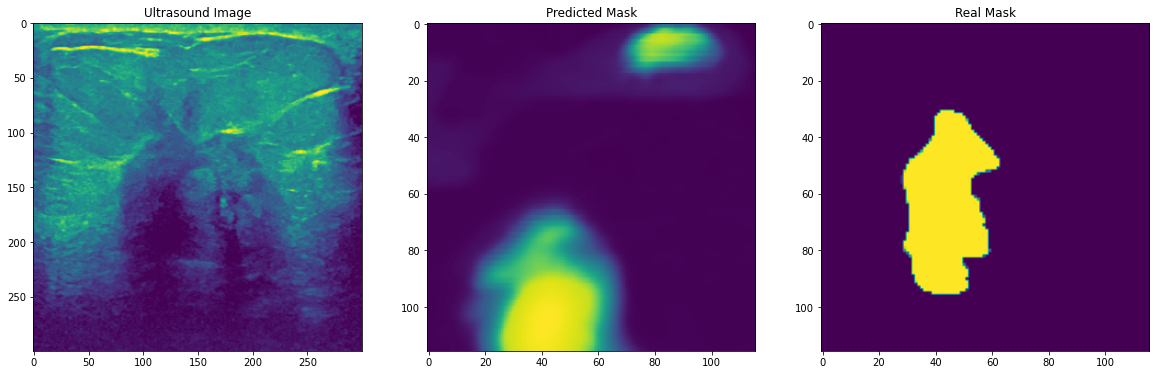

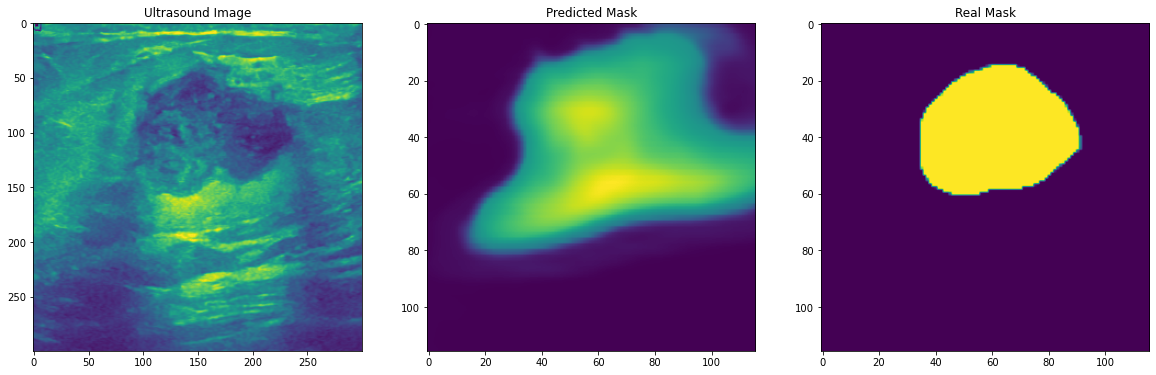

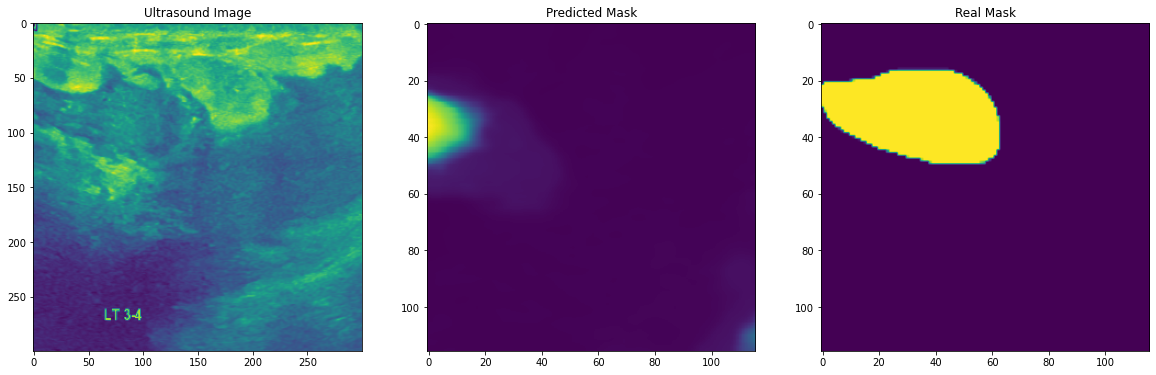

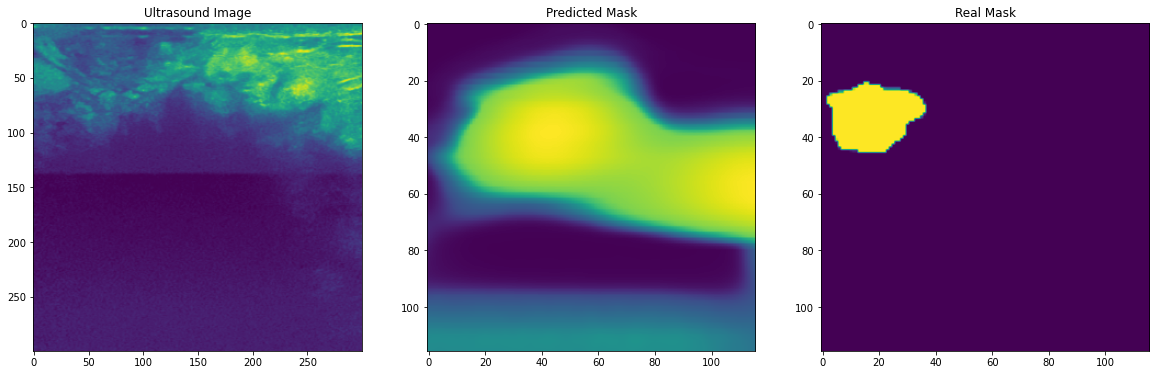

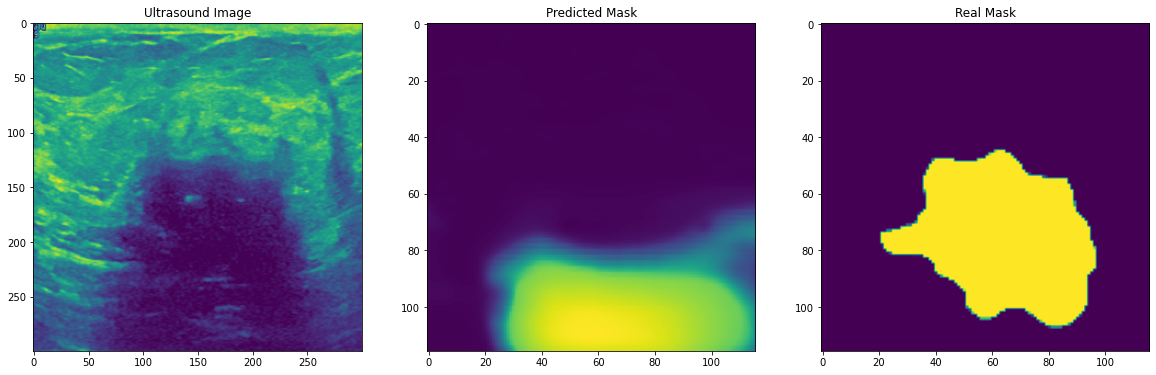

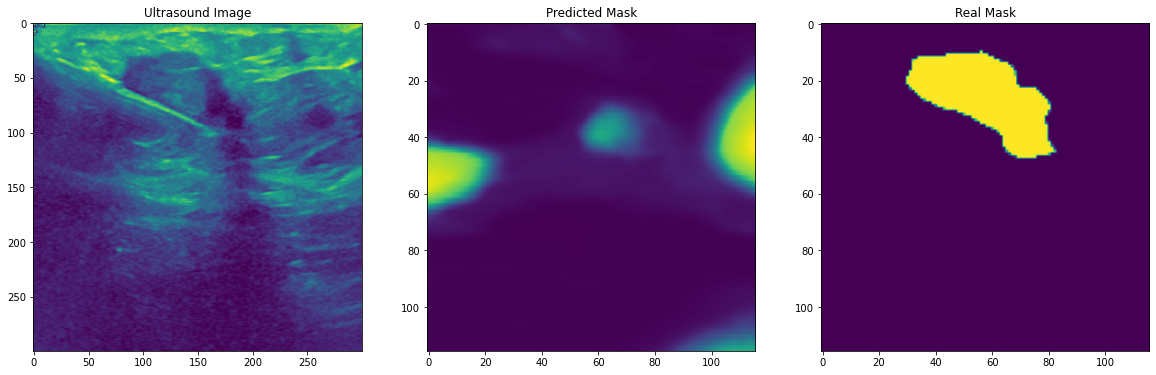

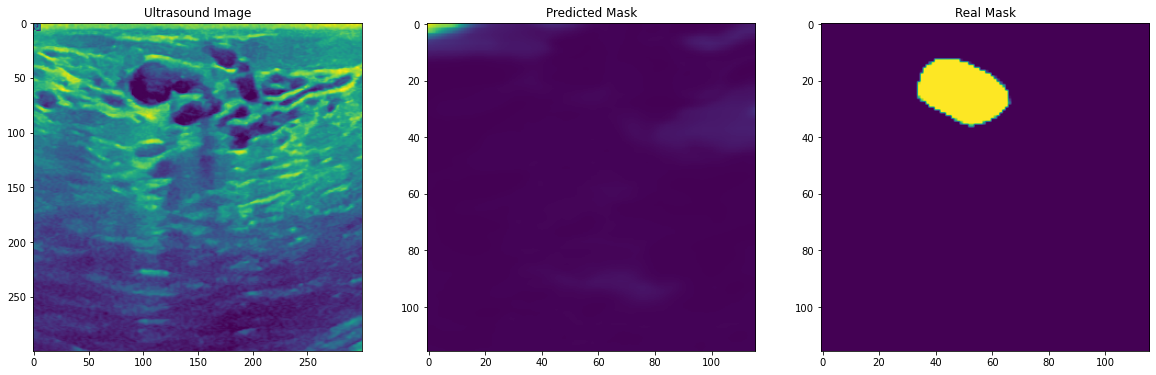

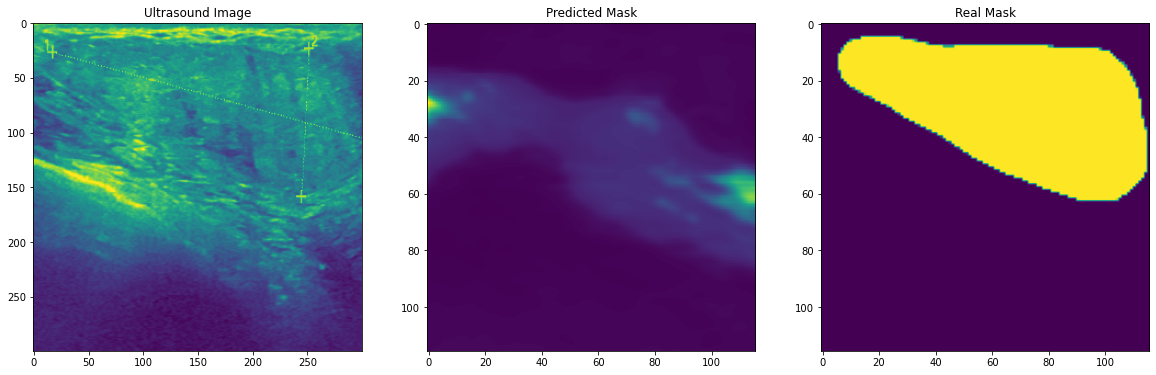

In [112]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = new_model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])  
    plt.show()
    
    if i == n-1:
        break